## Utilisation des corpus nltk

In [1]:
import nltk
import re, string
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import names, stopwords, words
from nltk.corpus import wordnet as wn
from nltk.corpus import brown
from nltk.corpus import gutenberg
from nltk.stem import WordNetLemmatizer
from collections import Counter
WNlem = nltk.WordNetLemmatizer()
nltk.download('stopwords')
nltk.download('words')
nltk.download('brown')
nltk.download('names')
nltk.download('wordnet')
brownwords = set(brown.words())
wordlist = set(words.words('en'))
stopWords = set(stopwords.words('english'))
nameswords = set(names.words())
wordnet = set(wn.words())
def VerifMot(mot):
    if len(mot) <= 2 : return '' # suppression des mots courts
    if mot.find('http') == 0 : return ''  # supression des liens http
    mot = mot.lower()             # on réduit en minuscule
    mot = WNlem.lemmatize(mot)     # recherche de la forme canonique du mot
    if mot in stopWords:  return ''# suppression des mots courts ou de stop  
    return mot

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rapha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\rapha\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\rapha\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package names to
[nltk_data]     C:\Users\rapha\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rapha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Lecture du fichier test et épuration du texte

In [2]:
file = open('test.tsv','r',encoding="utf8")
alltxt = "" 
nt = 0       # nombre de ligne (tweet) du fichier test
TwtDict = {}
for line in file:
    ligne = line.split('\t')
    id = ligne[0]
    key = ligne[1]
    loc = ligne[2]
    txt = ligne[3]
    txt = re.sub(r'[^\w\s]',' ',txt) # suppression des caractères non alphanumériques et non blanc
    txt = re.sub(r'\d+',' ',txt) # suppression des chiffres et nombres
    txt = txt.lower()
    mots = word_tokenize(txt)
    txt = ''
    nt = nt + 1
    # if nt > 30 : break
    if nt == 1 : continue
    Twt  = []
    for mot in mots: 
        mot = VerifMot(mot)
        txt = txt + ' '+ mot
        Twt.append(mot)
    TwtDict[id] = Twt
    alltxt = alltxt + txt
motsall = re.findall(r'\w+', alltxt)
cntmotsall = Counter(motsall).most_common()
# print(cntmotsall)
max_cnt_mot = cntmotsall[0][1] 
max_freq_mot = (max_cnt_mot/nt)*100
print('nb Tweets:',nt,'max_cnt_mot:', max_cnt_mot)
file.close()

nb Tweets: 3264 max_cnt_mot: 167


## calcul de la probabilté bayésienne  DIS et NODis des tweets de test

0.4296033622274757 0.5702653007617546
N twt= 3264 N Dis= 1310 N Nod= 1953 %Dis= 40.13 %Nod= 59.83


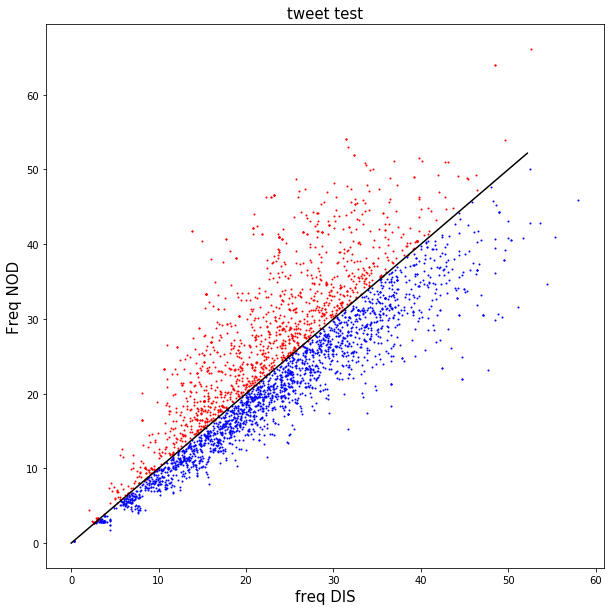

In [16]:
from matplotlib import pyplot as plt
import numpy as np
import math
%matplotlib inline
# lecture des probabilités DIS et NODis des mots 
FCxy = open('ProbaMot_dict.csv','r')
Rxy = {}
for line in FCxy :
    ligne = line.split(',')
    key = ligne[0]
    x = (ligne[1])
    y = (ligne[2].replace('\n',''))
    Rxy[key] = [x,y]  
Ptd = float(Rxy['PtdPtn'][0])
Ptn = float(Rxy['PtdPtn'][1])
print(Ptd,Ptn)
################################
def PrByTwt(twt) : # calcul des probabilités bayésiennes du tweet
    nmt = len(twt) # nombre de mot  dans le tweet
    PbD = 1 ; PbN = 1  # probabilités bayésienne DIS et NODis des tweets
    if not twt : return 0,0 
    for mot in twt: # parcourt des mots du tweet
        if mot in Rxy :
            Pd = float(Rxy[mot][0])
            Pn = float(Rxy[mot][1])
        else :
            Pd = 1 ; Pn = 1
        PbD = PbD*Pd  
        PbN = PbN*Pn
    PbD = PbD*Ptd
    PbN = PbN*Ptn
    return PbD,PbN
##########################################
plt.figure(figsize=(10, 10))
plt.title('tweet test',fontsize=15)
plt.xlabel('freq DIS',fontsize=15)
plt.ylabel('Freq NOD',fontsize=15)
### 
sub = open('submission_bayes.csv','w')
sub.write('id,target\n')
Prtwt = open('ProbTwtest.csv','w') # création du fichier avec les probas P_d et P_n du tweet
nDis = 0 ; nNod = 0
data = np.array([[0,0,0]])
proba = np.array([[0,0,0]])
xmax = 0 ; ymax = 0
for id, Twt in TwtDict.items():
    nid = int(id)
    PbDt,PbNt = PrByTwt(Twt)
    x = abs(math.log10(PbDt))
    if x > xmax : xmax = x
    y = abs(math.log10(PbNt))
    if y > ymax : ymax =y
    if PbDt > PbNt : 
        tag = '1'
        plt.scatter(x,y,c='red',s=1)
        nDis = nDis + 1
    else :
        tag = '0'
        plt.scatter(x,y,c='blue',s=1)
        nNod = nNod +1
    sub.write(id+','+tag+'\n')  # on écrit la submission
    row = np.array([[nid,x,y]])
    data = np.concatenate((data, row), axis=0)
data = np.delete(data,(0),axis=0)
# print("First five rows of data:\n", data[0:5])
np.savetxt('ProBTwtest.csv', data, delimiter=',') 
pDis = nDis/nt*100 ; pNod = nNod/nt*100
print('N twt=',nt,'N Dis=',nDis,'N Nod=',nNod,'%Dis=',round(pDis, 2),'%Nod=',round(pNod,2))
sub.close()
# tracé de la droite x=y
x = np.arange(0,xmax,xmax/10) 
y = x
plt.plot(x,y,c='black')
plt.show()